# **Load Libraies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Numpy & matplotlib for notebooks
%pylab inline

# Pandas for data analysis and manipulation
import pandas as pd

# Sparse matrix package for numeric data.
from scipy import sparse

# Module for word embedding (word2vector)
import gensim

# Module for progress monitoring
import tqdm

# Sklearn
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.svm import SVC # Support Vector Classification
from sklearn.ensemble import RandomForestClassifier # A meta-estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier for multinomial models
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # Exhaustive search over specified parameter values for a given estimator
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

import nltk
import re
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn

#XGBoost
from xgboost import XGBRegressor

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

# Joblib
import joblib # To save models

Populating the interactive namespace from numpy and matplotlib


In [6]:
arraypath = '/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/'
modelpath='/content/drive/MyDrive/Community Help /Abuse Text classification/Models/'
datapath='/content/drive/MyDrive/Community Help /Abuse Text classification/Data/'

# **Data Loading and Manipulation**

In [8]:
train_data = pd.read_csv(datapath+'df_Text_Abuse_final_unique.csv')
train_data.drop(['Unnamed: 0'],
  axis='columns', inplace=True)
train_data_1=train_data[train_data["CATEGORY_CLASS"]=="ABUSE"]
train_data_2=train_data[train_data["CATEGORY_CLASS"]=="NON ABUSE"]
train_data_2=train_data_2.sample(n=48000, random_state=42)
train_data_1.shape,train_data_2.shape

((48602, 2), (48000, 2))

In [10]:
train_data = pd.concat([train_data_1, train_data_2], axis=0)
train_data.shape

(96602, 2)

In [11]:
X = []
# the genders
y = []
# lengths of X elements
X_len = []
for index, row in train_data.iterrows():
    X.append(row["CONTENT"])
    X_len.append([len(row["CONTENT"])])
    y.append(row["CATEGORY_CLASS"])

# **Preprocessing**

In [12]:
# preprocessing functions
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# remove words that end with one or more identical letters
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_allcaps(text):
    caps = re.compile(r'([^a-z0-9()<>\'`\-]){2,}')
    return caps.sub(r'ALLCAPS', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [13]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [14]:
# tags Part of Speech (POS), because teh lemmatizer needs it
tag_map = defaultdict(lambda : wn.NOUN)
# wn does a grammatical analysis
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
# create lemmatizer
word_Lemmatized = WordNetLemmatizer()

def review_to_words(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)
    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    #stops = set(stopwords.words("english"))
    #meaningful_words = [w for w in words if not w in stops]
    Final_words = []
    for word, tag in pos_tag(words):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # returns lemmatized texts as strings
    return( " ".join(Final_words))

In [15]:
clean_train_comments = [review_to_words(x) for x in X]

<ipython-input-14-1e68d722f9d6>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()
<ipython-input-14-1e68d722f9d6>:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()


In [16]:
joblib.dump(clean_train_comments, arraypath+'clean_train_comments_abuse_XGB.pkl')
joblib.dump(X_len, arraypath+'X_len_abuse_XGB.pkl')
joblib.dump(y, arraypath+'y_abuse_XGB.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/y_abuse_XGB.pkl']

In [17]:
clean_train_comments=joblib.load(arraypath+'clean_train_comments_abuse_XGB.pkl')

# **Train Countvectorizer, Optimize Input for model Training**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer # Il CountVectorizer ha performato meglio
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",
                             max_features = 2000)
# converts in np array
train_data_features = vectorizer.fit_transform(clean_train_comments).toarray()


print(train_data_features.shape)
# print vocabulary
vocab = vectorizer.get_feature_names_out()
print(vocab)
import numpy as np

# counts how many times a word appearco
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

    # removes the 40 most utilized words
for _ in range(40):
    index = np.argmax(dist)
    train_data_features = np.delete(train_data_features, index, axis = 1)

train_data_features.shape

# np array
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)

# 5000 rows (one per author),  and 2000-40+1 (X_len) features
s.shape

# un np.array
y = np.array(y)

In [18]:
#from sklearn.feature_extraction.text import TfidfVectorizer # Il CountVectorizer ha performato meglio
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer2 = CountVectorizer(analyzer = "word",
                             max_features = 1961)
# converts in np array
train_data_features = vectorizer2.fit_transform(clean_train_comments).toarray()
print(train_data_features.shape)
train_data_features.shape
# np array
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)
s.shape
print(s.shape)

(96602, 1961)
(96602, 1962)


In [19]:
joblib.dump(vectorizer2, arraypath+'vectorizer_abuse_XGB.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/vectorizer_abuse_XGB.pkl']

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical,plot_model
le=LabelEncoder()
lbls=le.fit_transform(y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))

joblib.dump(lbls, arraypath+'lbls_XGB.pkl')
joblib.dump(classes, arraypath+'classes_abuse_XGB.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/classes_abuse_XGB.pkl']

In [ ]:
lbls=np.array(lbls)

# **Train data TruncatedSVD visualization**

In [ ]:
# Plot the test data along the 2 dimensions of largest variance
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','orange']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels ,cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})
            plt.title('BOW + lenght comments only')
            plt.savefig('foo.pdf')

fig = plt.figure(figsize=(8, 8))
plot_LSA(train_data_features, lbls)
plt.show()

# **Model Training and Prediction**

In [ ]:
# splits
X_train, X_valid, y_train, y_valid = train_test_split(s, lbls,
                                                      train_size=0.7, test_size=0.3,
                                                      random_state=0)

In [ ]:
joblib.dump(X_valid, arraypath+'X_valid_XGB.pkl')
joblib.dump(y_valid, arraypath+'y_valid_XGB.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/y_valid_XGB.pkl']

In [ ]:
X_train.shape

(77281, 1961)

In [ ]:
# XGBoost model with parameters set with a RandomGridSearch
my_model = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.01, n_jobs=4,subsample = 0.9,
                       min_child_weight = 1,max_depth=4,gamma=1.5,colsample_bytree=0.6 )

# cross_val_score resets parameters of my_model and fits it on X_train and t_train with cross validation (we did it for consistency).
###kfold = KFold(n_splits=10)
###results = cross_val_score(my_model, s,lbls, cv=kfold, scoring='roc_auc')
###print("roc = ", np.mean(results))

# fits
my_model.fit(X_train, y_train,
             early_stopping_rounds=80,
             #sample_weight = w,
             eval_set=[(X_valid, y_valid)],
             verbose=False)

In [ ]:
my_model = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.01, n_jobs=4,subsample = 0.9,
                       min_child_weight = 1,max_depth=4,gamma=1.5,colsample_bytree=0.6 )
my_model.fit(X_train, y_train,
             early_stopping_rounds=90,
             #sample_weight = w,
             eval_set=[(X_valid, y_valid)],
             verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=4, num_parallel_tree=None,
             objective='reg:logistic', predictor=None, ...)

In [ ]:
# In the fit function there is the early stop, that one may set iff there is a validation set.
# The early stop interrupts the training when themodel starts overfitting.
# But, the model that will predict the test will have no validation during training, so we get here a value and heuristicallly use it also when predicting test.
print(my_model.best_iteration)

9999


In [ ]:
y_score = my_model.predict(X_valid)

In [ ]:
y_score

array([[0.3825301 , 0.59817845],
       [0.19167757, 0.8020337 ],
       [0.0773447 , 0.9252914 ],
       ...,
       [0.86693823, 0.13546738],
       [0.8970127 , 0.1003407 ],
       [0.5195652 , 0.49510527]], dtype=float32)

In [ ]:
y_valid

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

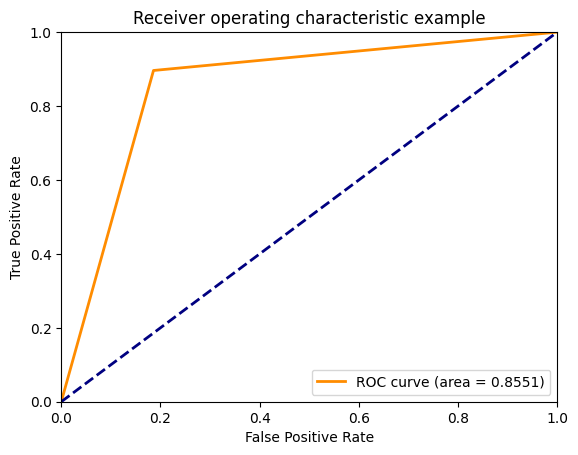

In [ ]:
# ROC plot


# Roc Curve for validation data
fpr, tpr, thresholds = roc_curve(y_valid.argmax(axis=1), y_score.argmax(axis=1))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid.argmax(axis=1),y_score.argmax(axis=1)))

[[7925 1810]
 [ 995 8591]]


In [ ]:
# Validation predictions
y_predict = my_model.predict(X_valid)

In [ ]:
# Verification
roc(y_valid,y_predict)

0.9331569129393994

In [ ]:
# Save predictions
np.save(modelpath+'y_predict_XGB.csv',y_predict)

In [ ]:
# ROC evaluated on train set to evaluate overfitting
y_predict = my_model.predict(X_train)
roc(y_train,y_predict)

0.9543464612193004

In [ ]:
joblib.dump(my_model, modelpath+'my_model_XGBRegressor.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/Models/my_model_XGBRegressor.pkl']

# Appendix: *GridSearch*

Thsi is the RandomGridSearch that we used to estimate the best parameters for the XGBoost

```python
from xgboost import XGBRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

xgb = XGBRegressor(learning_rate=0.01, n_estimators=10000, objective='reg:logistic',
                    silent=True, nthread=1)

#n_esimators si assume indipendente e quindi ottimizzato a parte

 params = {
        'min_child_weight': [1,8],
        'gamma': [0.6,0.8],
        'subsample': [0.9],
        'colsample_bytree': [0.6],
        'max_depth': [4],
        'scale_pos_weight': [1,2.70, 10, 25, 50, 75, 100, 1000]
        }

folds = 5
param_comb = 18 #in realtà di più

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=0)

print('\n Best score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
```